In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [5]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
import json
import sys
# import imp
import random
import copy
import gc
import tables

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(torch.device('cuda:0')))

NVIDIA GeForce RTX 3090


# Load DR4 isat

In [10]:
npz_file = np.load('../data_aux/DR4_isat.npz', allow_pickle=True)

In [18]:
isat_p22 = npz_file['isat_p22'][()]
isat_p29 = npz_file['isat_p29'][()]
isat_p34 = npz_file['isat_p34'][()]
pos_x_p22 = npz_file['pos_x_p22'][()]
pos_x_p29 = npz_file['pos_x_p29'][()]
pos_x_p34 = npz_file['pos_x_p34'][()]
pos_z = npz_file['pos_z'][()]
timebase = npz_file['timebase'][()]

In [56]:
shotcount=4

In [19]:
isat_p22

{'01': array([[[ 2.9636469e-05,  2.9636469e-05, -9.0935464e-05, ...,
           2.9636469e-05,  2.9636469e-05,  1.5020851e-04],
         [-8.7040986e-05, -8.7040986e-05,  3.3530941e-05, ...,
           3.3530941e-05,  3.3530941e-05,  3.3530941e-05],
         [ 2.4608573e-05, -9.5963354e-05,  2.4608573e-05, ...,
           1.4518063e-04,  2.4608573e-05,  1.4518063e-04],
         [ 1.3142136e-05,  1.3142136e-05,  1.3142136e-05, ...,
           1.3142136e-05,  1.3142136e-05,  1.3142136e-05]],
 
        [[-1.1347037e-04,  7.1015570e-06,  7.1015570e-06, ...,
           7.1015570e-06,  7.1015570e-06,  7.1015570e-06],
         [-9.6542077e-05,  2.4029847e-05,  2.4029847e-05, ...,
          -9.6542077e-05,  2.4029847e-05,  2.4029847e-05],
         [ 2.0798501e-05, -9.9773431e-05, -9.9773431e-05, ...,
           1.4137055e-04,  2.0798501e-05,  2.0798501e-05],
         [ 2.1714826e-05,  2.1714826e-05, -9.8857105e-05, ...,
           2.1714826e-05,  2.1714826e-05, -9.8857105e-05]],
 
        [[-9

In [20]:
dt = (timebase[-1] - timebase[0]) / 250000

<IPython.core.display.Javascript object>


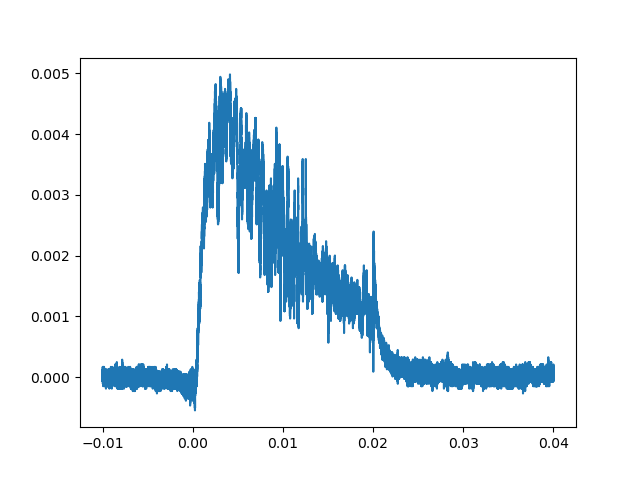

In [25]:
plt.figure()
plt.plot(timebase, isat_p22['07'][10, 0, :])

# Load model

In [26]:
ens_name = 'beta-NLL_wd-0.0'

In [27]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/training_runs/')

In [28]:
runs = sorted(os.listdir(ens_name))
if 'plots' in runs:
    runs.remove('plots')

In [29]:
runs

['2024-09-11_16h-34m-43s',
 '2024-09-11_17h-06m-22s',
 '2024-09-11_17h-37m-46s',
 '2024-09-11_18h-09m-16s',
 '2024-09-11_18h-40m-47s']

In [30]:
model_paths = [ens_name + "/" + run for run in runs]

model_versions = ["checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738"]

In [31]:
models = []
for model_path, model_version in zip(model_paths, model_versions):
    print("Loading model " + model_path + " version " + model_version)
    os.chdir("/home/phil/Desktop/profile-predict/PP1/training_runs/" + model_path + "/")

    spec = importlib.util.spec_from_file_location("train_dense_beta_NLL_copy", "train_dense_beta_NLL_copy.py")
    loaded_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(loaded_module)
    with open("hyperparams.json") as json_f:
        hyperparams = json.loads(json_f.read())

    # imp.reload(ebm)
    model = loaded_module.ModelClass(hyperparams).to(device)
    # ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
    ckpt = torch.load(model_version + ".pt")

    model_dict = OrderedDict()
    pattern = re.compile('module.')
    state_dict = ckpt['model_state_dict']
    for k,v in state_dict.items():
        if re.search("module", k):
            model_dict[re.sub(pattern, '', k)] = v
        else:
            model_dict = state_dict
    model.load_state_dict(model_dict, strict=True)

    data_train_path = "/home/phil/Desktop/profile-predict/datasets/" + hyperparams['dataset']

    print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))
    
    models.append(model)
# for model in models:
#     model = model.cpu()

Loading model beta-NLL_wd-0.0/2024-09-11_16h-34m-43s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-06m-22s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-37m-46s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-09m-16s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-40m-47s version checkpoints/model-499-738
Number of parameters: 201218


/home/phil/anaconda3/envs/gr-id-pinn-2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [32]:
data_train_path = "/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_isat_04_train_cv-0.npz"

In [33]:
train_npz = np.load(data_train_path)
x_mean = train_npz['x_mean']
x_ptp = train_npz['x_ptp']
y_mean = train_npz['y_mean']
y_ptp = train_npz['y_ptp']

In [34]:
RMSE = 0.054 * y_ptp

In [35]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/')
# os.makedirs('plots/' + model_version[12:], exist_ok=True)
# os.makedirs('plots/', exist_ok=True)

# Compare DR4

In [167]:
# x_offset = np.array([8.28375594, 12.43209571, 8.50826234]) - 10 / np.sqrt(2)
# y_offset = np.array([-8.01434826, -7.41275231, -9.74304756]) + 10 / np.sqrt(2)

In [168]:
# x_coords_01 = np.array([np.mean(pos_x_p22, axis=1), np.mean(pos_x_p29, axis=1), np.mean(pos_x_p34, axis=1)]) / np.sqrt(2) + x_offset[:, np.newaxis]
# y_coords_01 = -np.array([np.mean(pos_x_p22, axis=1), np.mean(pos_x_p29, axis=1), np.mean(pos_x_p34, axis=1)]) / np.sqrt(2) + y_offset[:, np.newaxis]

In [36]:
pos_z

array([990.45, 766.8 , 607.05])

In [152]:
settings_strongest = [500, 500, 1500, 90, 150, 38]
settings_weakest = [1000, 750, 250, 75, 150, 5]
settings_intermediate = [2000, 1250, 750, 90, 120, 38]
settings_LHS_30 = [1000, 500, 500, 90, 90, 38]

In [153]:
inputs = np.zeros((6 * 4, 12), dtype=np.float32)
# inputs[:, 0] = 822  # interpolating
# inputs[:, 1] = 500
# inputs[:, 2] = 1500
# inputs[:, 3] = 90 
# inputs[:, 4] = 160 
# inputs[:, 5] = 38
inputs[0:6, 0:6] = settings_strongest
inputs[6:12, 0:6] = settings_weakest
inputs[12:18, 0:6] = settings_intermediate
inputs[18:24, 0:6] = settings_LHS_30

inputs[:, 6] = 0
inputs[:, 7] = 0
inputs[:, 8] = np.tile(np.array([pos_z[0], 890, 840, pos_z[1], 690, pos_z[2]]), 4)
inputs[:, 9] = 0
inputs[:, 10] = 1
inputs[:, 11] = 0
model_inputs = (inputs - x_mean) / x_ptp

In [154]:
model_predictions = []
for model in models:
    model_predictions.append(model(torch.tensor(model_inputs, dtype=torch.float32, device='cuda')).cpu().detach().numpy().astype(np.float64))
    model = None
    torch.cuda.empty_cache()
predictions = np.array(model_predictions)

In [155]:
pred_mean = np.mean(predictions[:, :, 0], axis=0)
pred_var = (np.mean(predictions[:, :, 1] + predictions[:, :, 0] ** 2, axis=0) - pred_mean ** 2) * y_ptp ** 2
pred_aleatoric = (np.mean(predictions[:, :, 1], axis=0)) * y_ptp ** 2
pred_epistemic = (np.mean(predictions[:, :, 0] ** 2, axis=0) - pred_mean ** 2)  * y_ptp ** 2
pred_mean = pred_mean * y_ptp + y_mean

In [156]:
plot_z = np.array([pos_z[0], 890, 840, pos_z[1], 690, pos_z[2]])

In [157]:
pred_mean.shape

(24,)

In [161]:
strongest_pred_var = pred_var[0:6]
strongest_pred_aleatoric  = pred_aleatoric[0:6]
strongest_pred_epistemic  = pred_epistemic[0:6]
strongest_pred_mean  = pred_mean[0:6]
strongest_predictions = predictions[:, 0:6]

weakest_pred_var = pred_var[6:12]
weakest_pred_aleatoric  = pred_aleatoric[6:12]
weakest_pred_epistemic  = pred_epistemic[6:12]
weakest_pred_mean  = pred_mean[6:12]
weakest_predictions = predictions[:, 6:12]

intermediate_pred_var = pred_var[12:18]
intermediate_pred_aleatoric  = pred_aleatoric[12:18]
intermediate_pred_epistemic  = pred_epistemic[12:18]
intermediate_pred_mean  = pred_mean[12:18]
intermediate_predictions = predictions[:, 12:18]

LHS_30_pred_var = pred_var[18:24]
LHS_30_pred_aleatoric  = pred_aleatoric[18:24]
LHS_30_pred_epistemic  = pred_epistemic[18:24]
LHS_30_pred_mean  = pred_mean[18:24]
LHS_30_predictions = predictions[:, 18:24]

## Strongest

<IPython.core.display.Javascript object>


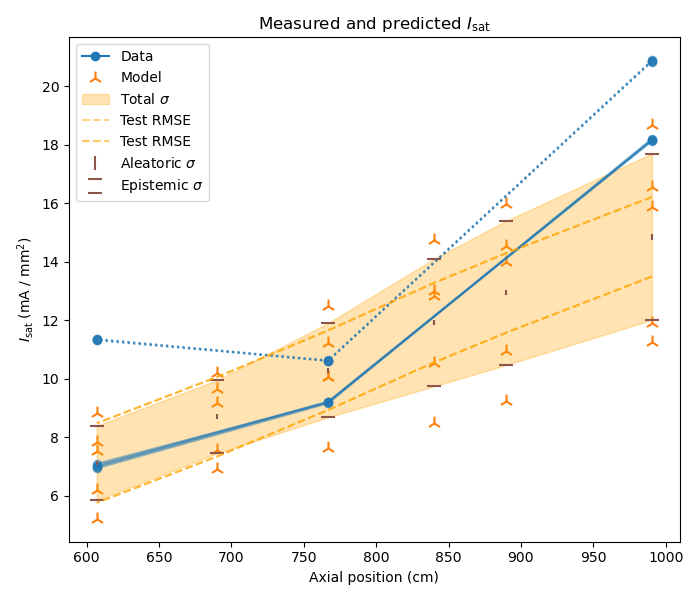

In [206]:
# plt.figure(figsize=(4.5, 3.5))
plt.figure(figsize=(7, 6))

pidx = 21

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

dr='02'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor_03, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor_03, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5, ls='dotted')

dr='05'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5)
    
plt.plot([], [], marker='o', color='tab:blue', label='Data', alpha=1)

# Plot model predictions
for i in range(len(models)):
    plt.scatter(plot_z, (strongest_predictions[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=100)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)


plt.errorbar(plot_z, strongest_pred_mean[:] * 1e3, yerr=np.sqrt(strongest_pred_aleatoric[:]) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', label=r'Aleatoric $\sigma$')
plt.errorbar(plot_z, strongest_pred_mean[:] * 1e3, yerr=np.sqrt(strongest_pred_epistemic[:]) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', label=r'Epistemic $\sigma$')
plt.fill_between(plot_z, (strongest_pred_mean[:] + np.sqrt(strongest_pred_var[:])) * 1e3,
                 (strongest_pred_mean[:] - np.sqrt(strongest_pred_var[:])) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')
plt.plot(plot_z, (strongest_pred_mean[:] + RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed', label='Test RMSE')
plt.plot(plot_z, (strongest_pred_mean[:] - RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed')

plt.plot(plot_z, (strongest_pred_mean[:] + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(plot_z, (strongest_pred_mean[:] - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.legend()
# plt.legend(ncols=2, loc='lower right')
# plt.ylim(-3, 0.025 * 1e3)
plt.tight_layout()
# plt.savefig('plots/inference/measured-vs-predicted_160V.pdf')

## Weakest

<IPython.core.display.Javascript object>


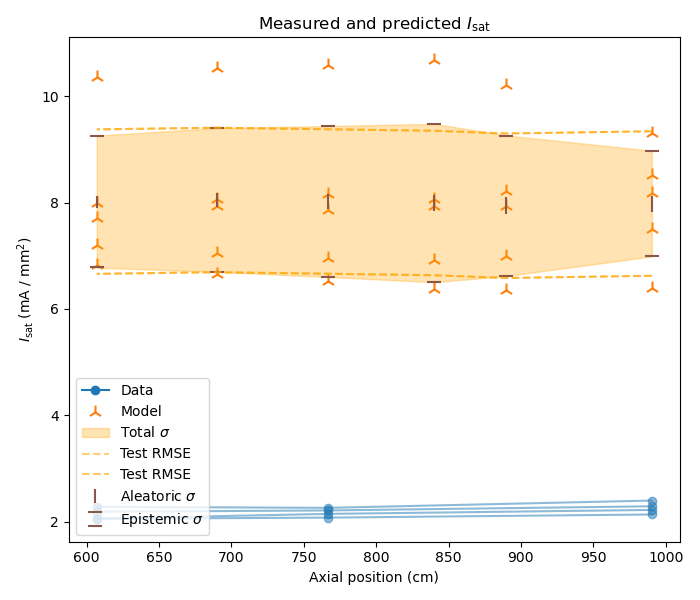

In [191]:
# plt.figure(figsize=(4.5, 3.5))
plt.figure(figsize=(7, 6))

pidx = 21

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

# dr='03'
# for i in range(shotcount):
#     plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]), np.mean(isat_p29[dr][5, i, 100000:150000]), np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
#              marker='o', color='tab:blue', alpha=0.5, linestyle='dotted')

dr='07'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5)
    
plt.plot([], [], marker='o', color='tab:blue', label='Data', alpha=1)

# Plot model predictions
for i in range(len(models)):
    plt.scatter(plot_z, (weakest_predictions[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=100)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)


plt.errorbar(plot_z, weakest_pred_mean[:] * 1e3, yerr=np.sqrt(weakest_pred_aleatoric[:]) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', label=r'Aleatoric $\sigma$')
plt.errorbar(plot_z, weakest_pred_mean[:] * 1e3, yerr=np.sqrt(weakest_pred_epistemic[:]) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', label=r'Epistemic $\sigma$')
plt.fill_between(plot_z, (weakest_pred_mean[:] + np.sqrt(weakest_pred_var[:])) * 1e3,
                 (weakest_pred_mean[:] - np.sqrt(weakest_pred_var[:])) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')
plt.plot(plot_z, (weakest_pred_mean[:] + RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed', label='Test RMSE')
plt.plot(plot_z, (weakest_pred_mean[:] - RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed')

plt.plot(plot_z, (weakest_pred_mean[:] + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(plot_z, (weakest_pred_mean[:] - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.legend()
# plt.legend(ncols=2, loc='lower right')
# plt.ylim(-3, 0.025 * 1e3)
plt.tight_layout()
# plt.savefig('plots/inference/measured-vs-predicted_160V.pdf')

## Intermediate

<IPython.core.display.Javascript object>


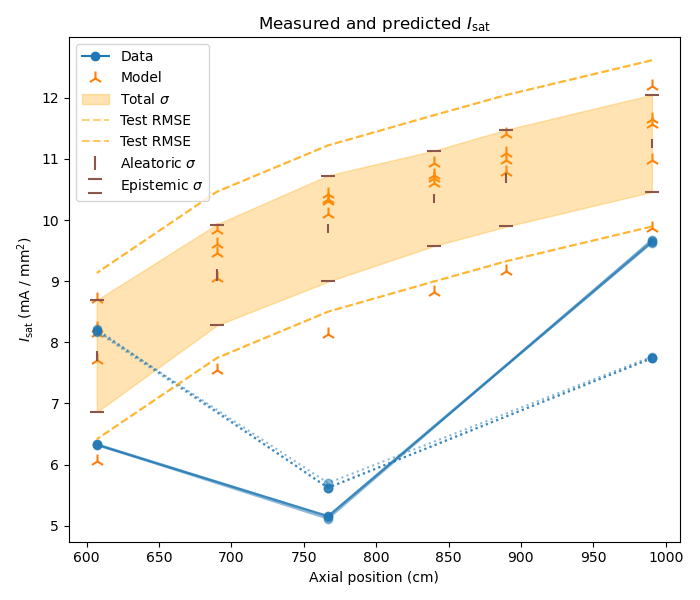

In [189]:
# plt.figure(figsize=(4.5, 3.5))
plt.figure(figsize=(7, 6))

pidx = 21

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

dr='04'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]), np.mean(isat_p29[dr][5, i, 100000:150000]), np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5, ls='dotted')

dr='08'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5)
    
plt.plot([], [], marker='o', color='tab:blue', label='Data', alpha=1)

# Plot model predictions
for i in range(len(models)):
    plt.scatter(plot_z, (intermediate_predictions[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=100)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)


plt.errorbar(plot_z, intermediate_pred_mean[:] * 1e3, yerr=np.sqrt(intermediate_pred_aleatoric[:]) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', label=r'Aleatoric $\sigma$')
plt.errorbar(plot_z, intermediate_pred_mean[:] * 1e3, yerr=np.sqrt(intermediate_pred_epistemic[:]) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', label=r'Epistemic $\sigma$')
plt.fill_between(plot_z, (intermediate_pred_mean[:] + np.sqrt(intermediate_pred_var[:])) * 1e3,
                 (intermediate_pred_mean[:] - np.sqrt(intermediate_pred_var[:])) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')
plt.plot(plot_z, (intermediate_pred_mean[:] + RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed', label='Test RMSE')
plt.plot(plot_z, (intermediate_pred_mean[:] - RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed')

plt.plot(plot_z, (intermediate_pred_mean[:] + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(plot_z, (intermediate_pred_mean[:] - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.legend()
# plt.legend(ncols=2, loc='lower right')
# plt.ylim(-3, 0.025 * 1e3)
plt.tight_layout()
# plt.savefig('plots/inference/measured-vs-predicted_160V.pdf')

## Training set case (DR2 run 10)

<IPython.core.display.Javascript object>


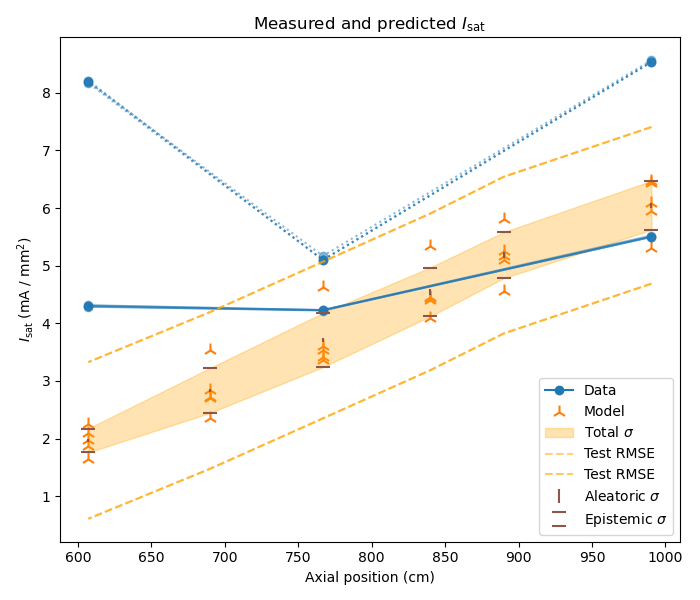

In [207]:
# plt.figure(figsize=(4.5, 3.5))
plt.figure(figsize=(7, 6))

pidx = 21

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
dr='04'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor_03, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor_03, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5, ls='dotted')

dr='09'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][5, i, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5)
    
plt.plot([], [], marker='o', color='tab:blue', label='Data', alpha=1)

# Plot model predictions
for i in range(len(models)):
    plt.scatter(plot_z, (LHS_30_predictions[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=100)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)


plt.errorbar(plot_z, LHS_30_pred_mean[:] * 1e3, yerr=np.sqrt(LHS_30_pred_aleatoric[:]) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', label=r'Aleatoric $\sigma$')
plt.errorbar(plot_z, LHS_30_pred_mean[:] * 1e3, yerr=np.sqrt(LHS_30_pred_epistemic[:]) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', label=r'Epistemic $\sigma$')
plt.fill_between(plot_z, (LHS_30_pred_mean[:] + np.sqrt(LHS_30_pred_var[:])) * 1e3,
                 (LHS_30_pred_mean[:] - np.sqrt(LHS_30_pred_var[:])) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')
plt.plot(plot_z, (LHS_30_pred_mean[:] + RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed', label='Test RMSE')
plt.plot(plot_z, (LHS_30_pred_mean[:] - RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed')

plt.plot(plot_z, (LHS_30_pred_mean[:] + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(plot_z, (LHS_30_pred_mean[:] - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.legend()
# plt.legend(ncols=2, loc='lower right')
# plt.ylim(-3, 0.025 * 1e3)
plt.tight_layout()
# plt.savefig('plots/inference/measured-vs-predicted_160V.pdf')

# Adjust isat calibration

<IPython.core.display.Javascript object>


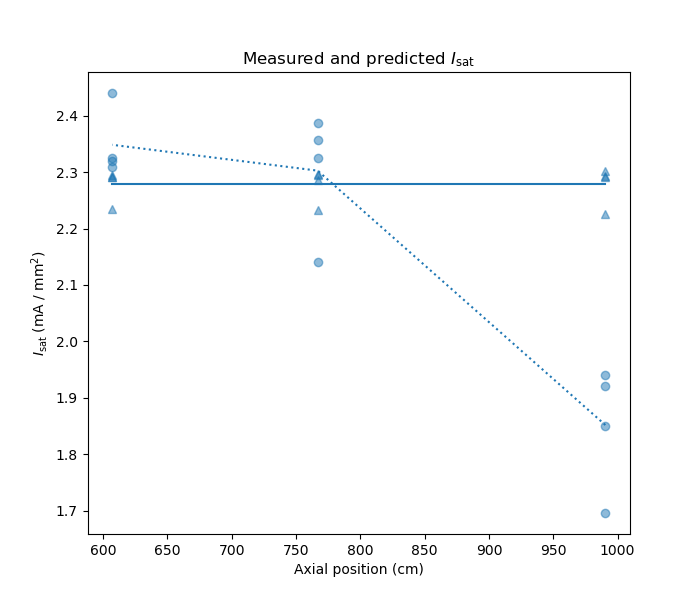

In [193]:
plt.figure(figsize=(7, 6))

pidx = 21

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

dr='03'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, i, 100000:150000]), np.mean(isat_p29[dr][5, i, 100000:150000]), np.mean(isat_p34[dr][5, i, 100000:150000])]) * 1e3,
             marker='o', color='tab:blue', alpha=0.5, lw=0)
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][5, :, 100000:150000]), np.mean(isat_p29[dr][5, :, 100000:150000]), np.mean(isat_p34[dr][5, :, 100000:150000])]) * 1e3,
             color='tab:blue', alpha=1, linestyle='dotted')

dr='07'
for i in range(shotcount):
    plt.plot(pos_z, np.array([np.mean(isat_p22[dr][10, i, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, i, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, i, 100000:150000])]) * 1e3,
             marker='^', color='tab:blue', alpha=0.5, lw=0)
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3,
             color='tab:blue', alpha=1)

In [ ]:
dr='07'

<IPython.core.display.Javascript object>


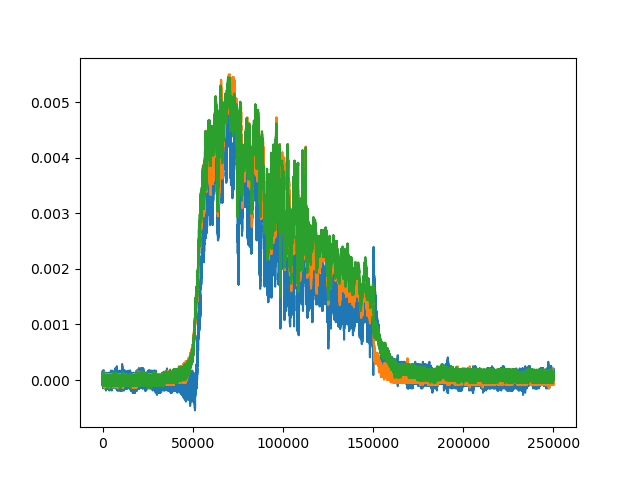

In [179]:
plt.figure()
plt.plot(isat_p22[dr][10, 0, :])
plt.plot(isat_p29[dr][10, 0, :])
plt.plot(isat_p34[dr][10, 0, :])

In [195]:
np.mean(isat_p22['07'][10, :, 100000:150000])
np.mean(isat_p29['07'][10, :, 100000:150000])
np.mean(isat_p34['07'][10, :, 100000:150000])

0.0022780995

In [260]:
isat_p34['07'].shape

(41, 4, 250000)

In [197]:
p29_factor = np.mean(isat_p34['07'][10, :, 100000:150000]) / np.mean(isat_p29['07'][10, :, 100000:150000])

In [199]:
p22_factor = np.mean(isat_p34['07'][10, :, 100000:150000]) / np.mean(isat_p22['07'][10, :, 100000:150000])

In [204]:
p29_factor_03 = np.mean(isat_p34['03'][10, :, 100000:150000]) / np.mean(isat_p29['03'][10, :, 100000:150000])

In [205]:
p22_factor_03 = np.mean(isat_p34['03'][10, :, 100000:150000]) / np.mean(isat_p22['03'][10, :, 100000:150000])

In [263]:
p22_factor

1.469735

In [264]:
p29_factor

1.068915

In [265]:
dr='05'
print(np.std(np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3))
dr='08'
print(np.std(np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3))
dr='07'
print(np.std(np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3))

6.603997
1.9514147
0.0


1.9069818

0.049410127

<IPython.core.display.Javascript object>


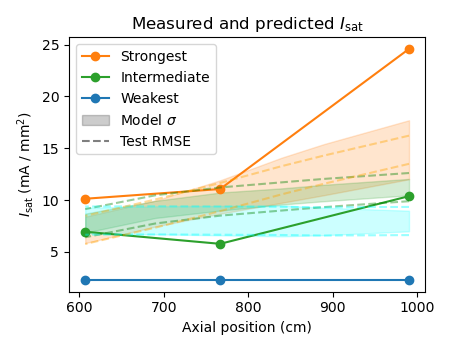

In [287]:
plt.figure(figsize=(4.5, 3.5))
dr='05'
# for i in range(shotcount):
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3,
         marker='o', color='tab:orange', alpha=1.0, label='Strongest')
    
dr='08'
# for i in range(shotcount):
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3,
         marker='o', color='tab:green', alpha=1.0, label='Intermediate')

dr='07'
# for i in range(shotcount):
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][10, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][10, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3,
         marker='o', color='tab:blue', alpha=1.0, label='Weakest')
    

plt.fill_between(plot_z, (strongest_pred_mean[:] + np.sqrt(strongest_pred_var[:])) * 1e3,
                 (strongest_pred_mean[:] - np.sqrt(strongest_pred_var[:])) * 1e3, alpha=0.2, color='tab:orange')
plt.fill_between(plot_z, (intermediate_pred_mean[:] + np.sqrt(intermediate_pred_var[:])) * 1e3,
                 (intermediate_pred_mean[:] - np.sqrt(intermediate_pred_var[:])) * 1e3, alpha=0.2, color='tab:green')
plt.fill_between(plot_z, (weakest_pred_mean[:] + np.sqrt(weakest_pred_var[:])) * 1e3,
                 (weakest_pred_mean[:] - np.sqrt(weakest_pred_var[:])) * 1e3, alpha=0.2, color='cyan')

plt.plot(plot_z, (intermediate_pred_mean[:] + RMSE) * 1e3, alpha=0.4, color='green', linestyle='dashed')
plt.plot(plot_z, (intermediate_pred_mean[:] - RMSE) * 1e3, alpha=0.4, color='green', linestyle='dashed')
plt.plot(plot_z, (weakest_pred_mean[:] + RMSE) * 1e3, alpha=0.4, color='cyan', linestyle='dashed')
plt.plot(plot_z, (weakest_pred_mean[:] - RMSE) * 1e3, alpha=0.4, color='cyan', linestyle='dashed')
plt.plot(plot_z, (strongest_pred_mean[:] + RMSE) * 1e3, alpha=0.4, color='orange', linestyle='dashed')
plt.plot(plot_z, (strongest_pred_mean[:] - RMSE) * 1e3, alpha=0.4, color='orange', linestyle='dashed')


plt.fill_between([], [], [], alpha=0.2, color='black', label=r'Model $\sigma$')
plt.plot([], [], label='Test RMSE', linestyle='dashed', color='black', alpha=0.5)

# plt.ylim(0, 20)

plt.legend()

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
plt.tight_layout()
# plt.savefig('plots/inference/axial-var_prediction-vs-measurement.pdf')

In [250]:
np.std(np.linspace(0, 10, 11))

3.1622776601683795

In [249]:
np.std(np.linspace(0, 10, 3))

3.5355339059327378

<IPython.core.display.Javascript object>


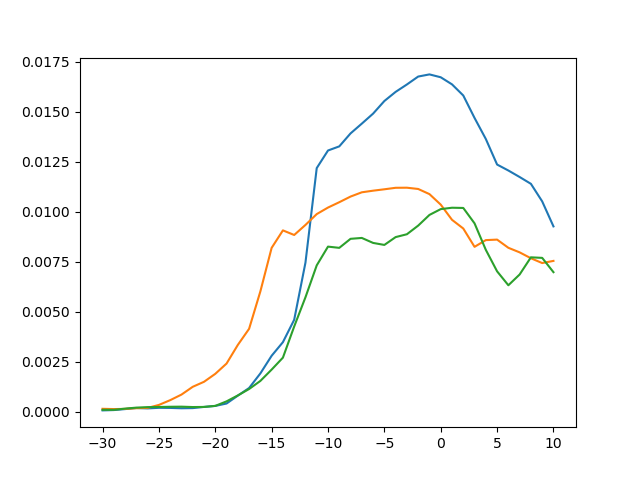

In [285]:
plt.figure()
dr='05'
plt.plot(np.linspace(10, -30, 41), np.mean(isat_p22[dr][:, :, 100000:150000], axis=(1,2)))
plt.plot(np.linspace(10, -30, 41), np.mean(isat_p29[dr][:, :, 100000:150000], axis=(1,2)))
plt.plot(np.linspace(10, -30, 41), np.mean(isat_p34[dr][:, :, 100000:150000], axis=(1,2)))

In [ ]:
plt.figure()
plt.plot(pos_z, np.array([np.mean(isat_p22[dr][:, :, 100000:150000]) * p22_factor, np.mean(isat_p29[dr][:, :, 100000:150000]) * p29_factor, np.mean(isat_p34[dr][10, :, 100000:150000])]) * 1e3,
         marker='o', color='tab:orange', alpha=1.0, label='Strongest')